# Naive RAG

## Quy trình

Thực hiện `Naive RAG`, hệ thống RAG cơ bản có 2 bước tiến trình, **Retrieve** (Truy xuất) và **Generate** (Tạo).

Bạn có thể xem cấu trúc trong hình ảnh bên dưới.

![](./assets/02-langgraph-naive-rag.png)

## Creating a Basic PDF-Based Retrieval Chain

Phần này tạo một Retrieval Chain dựa trên một **tài liệu PDF**. Đây là cấu trúc đơn giản nhất của một Retrieval Chain.

Trong `LangGraph`, Retrievers và Chains được tạo riêng biệt. Điều này cho phép xử lý chi tiết cho từng node.

In [1]:
import os
os.environ["LANGSMITH_TRACING"] = "false"
os.environ["LANGCHAIN_TRACING_V2"] = "false"

In [2]:
from rag.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain([
    'data/vneid.pdf'
]).create_chain()


In [3]:
# Create retriever and chain
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

First, use the `pdf_retriever` to fetch search results.

You can control the quantity to retrieve, by changing `self_k` argument in `pdf.py` file.

In [4]:
search_result = pdf_retriever.invoke(
    "Cách thêm giấy phép lái xe vào ứng dụng?"
)
search_result

[Document(id='02108b51-0a32-42a3-8a32-dffa9411e7d5', metadata={'source': 'data/vneid.pdf', 'file_path': 'data/vneid.pdf', 'page': 90, 'total_pages': 136, 'Author': 'Sâm Nhung', 'Creator': 'Microsoft® Word 2010', 'CreationDate': "D:20220801141803+07'00'", 'ModDate': "D:20220801141803+07'00'", 'Producer': 'Microsoft® Word 2010'}, page_content='nhập passcode, nhập đúng passcode \uf0e0 Hiển thị thông tin Đăng ký xe'),
 Document(id='297fbea9-e144-4083-8375-7ce778c1e1c2', metadata={'source': 'data/vneid.pdf', 'file_path': 'data/vneid.pdf', 'page': 91, 'total_pages': 136, 'Author': 'Sâm Nhung', 'Creator': 'Microsoft® Word 2010', 'CreationDate': "D:20220801141803+07'00'", 'ModDate': "D:20220801141803+07'00'", 'Producer': 'Microsoft® Word 2010'}, page_content='91\nHình 2.9-8 Màn hình chọn Đăng ký xe Hình 2.9-9 Thông tin đăng ký xe\n2.9.5 Giấy phép lái xe\n\uf076 Mục đích: Cho phép NSD xem thông tin giấy phép lái xe\n\uf076 Cách thực hiện:\n- Tại màn hình thông tin cá nhân, NSD nhấn Giấy phép lá

In [9]:
search_result[0].metadata

{'source': 'data/vneid.pdf',
 'file_path': 'data/vneid.pdf',
 'page': 90,
 'total_pages': 136,
 'Author': 'Sâm Nhung',
 'Creator': 'Microsoft® Word 2010',
 'CreationDate': "D:20220801141803+07'00'",
 'ModDate': "D:20220801141803+07'00'",
 'Producer': 'Microsoft® Word 2010'}

Pass the search result as context to the chain.

In [5]:
# Generate an answer based on the search results
answer = pdf_chain.invoke(
    {
        "question": "Cách thêm giấy phép lái xe vào ứng dụng?",
        "context": search_result,
        "chat_history": [],
    }
)
print(answer)

Dựa trên thông tin được cung cấp từ các văn bản, tôi có thể tóm tắt một số điểm chính về quy trình đăng ký và quản lý hồ sơ CCCD (Thẻ CCCD) như sau:

1. Đăng ký: Người dân có thể đăng ký trực tuyến qua ứng dụng hoặc website của cơ quan chức năng.

2. Quy trình:
   - Bước 1: Nhập thông tin cá nhân
   - Bước 2: Quét mã QR code trên thẻ CCCD gắn chip
   - Bước 3: Chụp ảnh chân dung theo hướng dẫn

3. Quản lý hồ sơ:
   - Có thể xem và quản lý các thông tin như giấy phép lái xe, thẻ BHYT, thuế, người phụ thuộc.
   - Cần nhập passcode để truy cập vào từng mục.

4. Các chức năng chính:
   - Chọn giấy phép lái xe
   - Xem thông tin đăng ký xe
   - Xem thông tin thẻ BHYT
   - Xem thông tin thuế
   - Xem thông tin người phụ thuộc

5. Lưu trữ ảnh: Ứng dụng sẽ lưu ảnh chân dung vào hồ sơ đăng ký.

Nếu bạn có câu hỏi cụ thể hơn về một bước nào đó trong quy trình, tôi rất vui lòng giúp đỡ!


## Defining State

`State` defines the **shared state** among the nodes and another nodes.

Typically, the `TypedDict` format is used.

In [6]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

# Define GraphState
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # Question
    context: Annotated[str, "Context"]  # Search results from the document
    answer: Annotated[str, "Answer"]  # Answer
    messages: Annotated[list, add_messages]  # Messages (accumulated list)

## Defining Nodes

`Nodes` : These are nodes that handle each stage, typically implemented as Python functions. Inputs and outputs are the State values.

[ **Note** ]  
- A `State` is taken as input, performs the defined logic, and returns an **updated** `State` .

In [ ]:
from rag.utils import format_docs
from rag.messages import messages_to_history

# Node that retrieve document
def retrieve_document(state: GraphState) -> GraphState:
    # Get the question from the state
    latest_question = state["question"]

    # Search the document to find relevant sections
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # Format the retrieved documents (to input into a prompt)
    retrieved_docs = format_docs(retrieved_docs)
    
    # Save the retrieved documents in the key named context
    return {"context": retrieved_docs} # type: ignore


# Node that generate answer
def llm_answer(state: GraphState) -> GraphState:
    # Get the question from the state
    latest_question = state["question"]

    # Get the retrieved documents from the state
    context = state["context"]

    # Call the chain to generate an answer
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    # Save the generated answer and (user question, answer) messages in the state
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    } # type: ignore

## Creating the Graph

`Edges` : Python functions that determine the next `Node` to execute based on the **current** `State` .

There can be general edges and conditional edges.

In [10]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Create a graph
workflow = StateGraph(GraphState)

# Define nodes
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# Define edges
workflow.add_edge("retrieve", "llm_answer")  # Retrieval -> Answer generation
workflow.add_edge("llm_answer", END)  # Answer generation -> End

# Set entry point for the graph
workflow.set_entry_point("retrieve")

# Set up a checkpointer
memory = MemorySaver()

# Compile the graph
app = workflow.compile(checkpointer=memory)

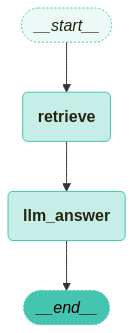

In [13]:
from rag.graphs import visualize_graph

visualize_graph(app)

## Executing the Graph

- Tham số `config` cung cấp các thông tin cấu hình cần thiết cho việc thực thi đồ thị.
- `recursion_limit`: Đặt giới hạn độ sâu đệ quy tối đa cho việc thực thi đồ thị.
- `inputs`: Cung cấp dữ liệu đầu vào cho việc thực thi đồ thị.

Hàm `stream_graph` bên dưới chỉ stream các node cụ thể.

Bạn có thể dễ dàng kiểm tra **streaming output** của một **node cụ thể**.


In [14]:
from langchain_core.runnables import RunnableConfig
from rag.messages import invoke_graph, stream_graph, random_uuid

config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

input = GraphState(
    question="Cách thêm giấy phép lái xe vào ứng dụng?"
) # type: ignore

invoke_graph(app, input, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
('user', 'Cách thêm giấy phép lái xe vào ứng dụng?')
('assistant', 'Tại màn hình thông tin cá nhân, nhấn vào Giấy phép lái xe \uf0e0 Hiển thị màn hình nhập passcode, sau khi nhập đúng passcode thì sẽ hiển thị thông tin giấy phép lái xe.\n\n**Nguồn**\n- data/vneid.pdf (92)')
